# Extinction

Define extinction as
$$
A_\lambda = +2.5\log\left( \frac{F_{\lambda 0}}{F_\lambda} \right)
$$

So, the extinction function can be interpreted as extinguished flux by
$$
F_\lambda = F_{\lambda 0} 10^{-0.4A_\lambda}.
$$



Many of us think about extinction in terms of magnitudes,
$$
\Delta m = -2.5\log\left(\int W_\lambda F_\lambda d\lambda\right) + 2.5\log\left(\int W_\lambda F_{\lambda 0} d\lambda \right)
$$
where $W$ is the filter transmission curve.

If $F_{\lambda 0}$ is the zero-point flux, then $\Delta m$ is the magnitude.  If, on the other hand, $F_0$ is the flux before the dust, then
$$
\Delta m = A = -2.5\log\left(\int W_\lambda F_{\lambda 0} 10^{-0.4A_\lambda} d\lambda\right) + 2.5\log\left(\int W_\lambda F_{\lambda 0} d\lambda \right)
$$

$$
= -2.5\log\left(\frac{\int W_\lambda F_{\lambda 0} 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda F_{\lambda 0} d\lambda} \right).
$$




The point here is that it is impossible to correctly calculate the magnitude extinction without the orginal flux.  If and only if the filter efficiency is constant in the band and the flux is constant in the band can one convert a "theory extinction curve" into magnitudes:
$$
\Delta m = -2.5\log\left(\frac{\int 10^{-0.4A_\lambda} d\lambda}{\int d\lambda}\right)
$$

As a shorthand, the average of $A_\lambda$ in the band, $A$, is the magnitude extinction.  In general, however, the band response and the source flux must be taken into consideration.  Many extinction curves have been determined to match photometry, not the other way around.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
run getFMext.py

In [3]:
x=np.arange(0.5,5,.01)

For example, consider the extinction curve from Fitzpatrick (1999) and the updated coefficients as in the FMunred IDL procedure.

In [15]:
f99_r3=getFMext(x,3.1,"f99")/3.1
f99_r2=getFMext(x,2.1,"f99")/2.1
f99_r4=getFMext(x,4.1,"f99")/4.1
fmunred_r3=getFMext(x,3.1,"fmunred")/3.1
fmunred_r2=getFMext(x,2.1,"fmunred")/2.1
fmunred_r4=getFMext(x,4.1,"fmunred")/4.1

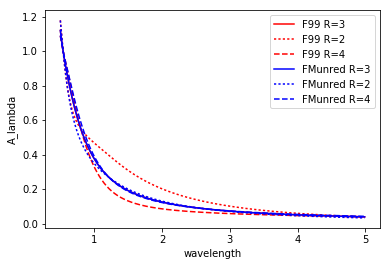

In [16]:
plt.plot(x,f99_r3,'r',label='F99 R=3')
plt.plot(x,f99_r2,'r',linestyle='dotted',label='F99 R=2')
plt.plot(x,f99_r4,'r',linestyle='dashed',label='F99 R=4')
plt.plot(x,fmunred_r3,'b',label='FMunred R=3')
plt.plot(x,fmunred_r2,'b',linestyle='dotted',label='FMunred R=2')
plt.plot(x,fmunred_r4,'b',linestyle='dashed',label='FMunred R=4')
plt.xlabel('wavelength')
plt.ylabel('A_lambda')
plt.legend(loc='best')
plt.show()

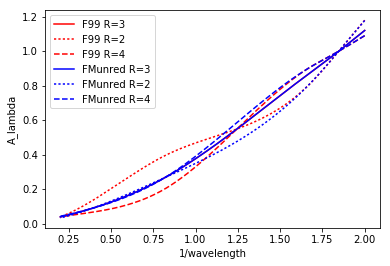

In [17]:
plt.plot(1./x,f99_r3,'r',label='F99 R=3')
plt.plot(1./x,f99_r2,'r',linestyle='dotted',label='F99 R=2')
plt.plot(1./x,f99_r4,'r',linestyle='dashed',label='F99 R=4')
plt.plot(1./x,fmunred_r3,'b',label='FMunred R=3')
plt.plot(1./x,fmunred_r2,'b',linestyle='dotted',label='FMunred R=2')
plt.plot(1./x,fmunred_r4,'b',linestyle='dashed',label='FMunred R=4')
plt.xlabel('1/wavelength')
plt.ylabel('A_lambda')
plt.legend(loc='best')
plt.show()

Next: Photometry and source flux